#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9515686909086312126
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3831907529483384064
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [6]:
data = pd.read_csv("data/data.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [7]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [8]:
As = data
Cd = data
Ni = data

In [9]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [10]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(1458, 16)
(1458, 16)
(1458, 16)


#### Eliminate outlier and train / test split

In [11]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [12]:
As = eli_outlier(As, "As")
Cd = eli_outlier(Cd, "Cd")
Ni = eli_outlier(Ni, "Ni")

In [13]:
As_X = As.drop(["As"], axis=1)
Cd_X = Cd.drop(["Cd"], axis=1)
Ni_X = Ni.drop(["Ni"], axis=1)

As_y = As["As"]
Cd_y = Cd["Cd"]
Ni_y = Ni["Ni"]

In [14]:
#As_y = np.log1p(As["As"])
#Cd_y = np.log1p(Cd["Cd"])
#Ni_y = np.log1p(Ni["Ni"])

In [15]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(1288, 15)
(1271, 15)
(1424, 15)


StandardScaler

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [17]:
As_train_re_X = pd.DataFrame(As_X_train, columns = ['pH','slope','altitude','profile_curve','planform_curve',
                                               'HYDGRP_A','HYDGRP_B','HYDGRP_C','HYDGRP_D','SOL_K1','CLAY1','SILT1','SAND1','ROCK1','distance'])

Cd_train_re_X = pd.DataFrame(Cd_X_train, columns = ['pH','slope','altitude','profile_curve','planform_curve',
                                               'HYDGRP_A','HYDGRP_B','HYDGRP_C','HYDGRP_D','SOL_K1','CLAY1','SILT1','SAND1','ROCK1','distance'])

Ni_train_re_X = pd.DataFrame(Ni_X_train, columns = ['pH','slope','altitude','profile_curve','planform_curve',
                                               'HYDGRP_A','HYDGRP_B','HYDGRP_C','HYDGRP_D','SOL_K1','CLAY1','SILT1','SAND1','ROCK1','distance'])

In [18]:
As_y_train = As_y_train.reset_index(drop = True)
Cd_y_train = Cd_y_train.reset_index(drop = True)
Ni_y_train = Ni_y_train.reset_index(drop = True)

In [19]:
As_train_re = pd.concat([As_train_re_X, As_y_train], axis=1)
Cd_train_re = pd.concat([Cd_train_re_X, Cd_y_train], axis=1)
Ni_train_re = pd.concat([Ni_train_re_X, Ni_y_train], axis=1)

#### Oversampling by SMOGN (SMOTE Regression)

In [20]:
import smogn

In [21]:
As_smogn = smogn.smoter(data = As_train_re, y = 'As', samp_method = 'extreme', rel_coef = 0.50)
Cd_smogn = smogn.smoter(data = Cd_train_re, y = 'Cd', samp_method = 'extreme', rel_coef = 0.50)
Ni_smogn = smogn.smoter(data = Ni_train_re, y = 'Ni', samp_method = 'extreme', rel_coef = 0.50)

dist_matrix:   1%|          | 2/248 [00:00<00:20, 11.97it/s]

r_index: 100%|##########| 97/97 [00:00<00:00, 655.26it/s]


In [22]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(827, 16)
(849, 16)
(902, 16)


In [23]:
As_y_train = As_smogn['As']
Cd_y_train = Cd_smogn['Cd']
Ni_y_train = Ni_smogn['Ni']

As_X_train = As_smogn.drop(['As'], axis = 1)
Cd_X_train = Cd_smogn.drop(['Cd'], axis = 1)
Ni_X_train = Ni_smogn.drop(['Ni'], axis = 1)

As_X_train = As_X_train.to_numpy()
Cd_X_train = Cd_X_train.to_numpy()
Ni_X_train = Ni_X_train.to_numpy()

In [24]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '''

' from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nAs_X_scaled = scaler.fit_transform(As_X)\nCd_X_scaled = scaler.fit_transform(Cd_X)\nNi_X_scaled = scaler.fit_transform(Ni_X)\n\nAs_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)\nCd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)\nNi_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '

MinMaxScaler

In [25]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [26]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(827, 15)
(849, 15)
(902, 15)


#### 10-Fold Crossvalidation

In [27]:
# kf = KFold(n_splits = 10, random_state = 42, shuffle = True)

#### Optuna Optimization

In [28]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [29]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR


def objectiveSVM(trial: Trial, X_train, y_train) -> float:
    C = trial.suggest_loguniform('C', 0.1, 100.0)
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    degree = trial.suggest_int('degree', 1, 5)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    model = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree)

    r2 = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)
    r2 = r2.mean()

    return r2


####  Optimization

In [30]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-28 23:40:17,540] A new study created in memory with name: svm_parameter_opt
[I 2023-08-28 23:40:18,784] Trial 0 finished with value: -150.38276464790223 and parameters: {'C': 74.20252139202185, 'epsilon': 0.01608505130874715, 'kernel': 'poly', 'degree': 4}. Best is trial 0 with value: -150.38276464790223.
[I 2023-08-28 23:40:18,897] Trial 1 finished with value: -0.022739952121485052 and parameters: {'C': 0.5049499947498829, 'epsilon': 0.08339126679973802, 'kernel': 'poly', 'degree': 1}. Best is trial 1 with value: -0.022739952121485052.
[I 2023-08-28 23:40:19,082] Trial 2 finished with value: -0.04850519950294914 and parameters: {'C': 0.4009837347722162, 'epsilon': 0.03477141538737624, 'kernel': 'linear', 'degree': 4}. Best is trial 1 with value: -0.022739952121485052.
[I 2023-08-28 23:40:21,670] Trial 3 finished with value: -3.8012448913989503 and parameters: {'C': 52.82967738993012, 'epsilon': 0.015822532652592, 'kernel': 'poly', 'degree': 3}. Best is trial 1 with value: -

Best r2:  0.11151035341320428
Best trial: {'C': 0.47684272826994245, 'epsilon': 0.2816363555103899, 'kernel': 'rbf', 'degree': 2}


In [31]:
optuna.visualization.plot_parallel_coordinate(study)

In [32]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 0.47684272826994245, 'epsilon': 0.2816363555103899, 'kernel': 'rbf', 'degree': 2}


In [33]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(As_X_train, As_y_train)

SVR(C=0.47684272826994245, degree=2, epsilon=0.2816363555103899)

In [34]:
y_train_pred = svm.predict(As_X_train)
y_test_pred = svm.predict(As_X_test)

In [35]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [36]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.37050815321313585
Test RMSE:  0.36141425239124597


In [37]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.30704933602190354
Test R2:  0.07981532736783992


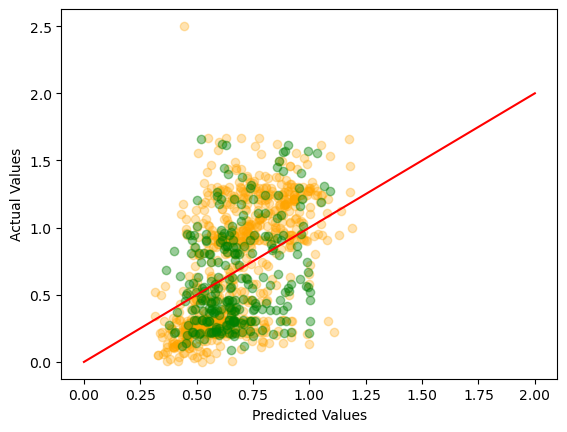

In [38]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 2.0], [0, 2.0], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [39]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-28 23:40:40,543] A new study created in memory with name: svm_parameter_opt
[I 2023-08-28 23:40:40,581] Trial 0 finished with value: -3.2700143296377546 and parameters: {'C': 2.9714006342722805, 'epsilon': 0.11741892152650076, 'kernel': 'poly', 'degree': 5}. Best is trial 0 with value: -3.2700143296377546.
[I 2023-08-28 23:40:40,593] Trial 1 finished with value: -0.4287952759128064 and parameters: {'C': 1.3079494022744982, 'epsilon': 0.6374098928931945, 'kernel': 'poly', 'degree': 1}. Best is trial 1 with value: -0.4287952759128064.
[I 2023-08-28 23:40:40,605] Trial 2 finished with value: -0.4287952759128064 and parameters: {'C': 26.01338018615394, 'epsilon': 0.28621219464692604, 'kernel': 'poly', 'degree': 3}. Best is trial 1 with value: -0.4287952759128064.
[I 2023-08-28 23:40:52,236] Trial 3 finished with value: -0.02296163508667144 and parameters: {'C': 25.82448914963412, 'epsilon': 0.038908140909748125, 'kernel': 'linear', 'degree': 1}. Best is trial 3 with value: -0.02

KeyboardInterrupt: 

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 1.6786154619762603, 'epsilon': 0.02369265989407749, 'kernel': 'rbf', 'degree': 3}


In [ ]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Cd_X_train, Cd_y_train)

SVR(C=1.6786154619762603, epsilon=0.02369265989407749)

In [ ]:
y_train_pred = svm.predict(Cd_X_train)
y_test_pred = svm.predict(Cd_X_test)

In [ ]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.11569694632080885
Test RMSE:  0.14462997025406332


In [ ]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.7167950440098796
Test R2:  0.5738292070813077


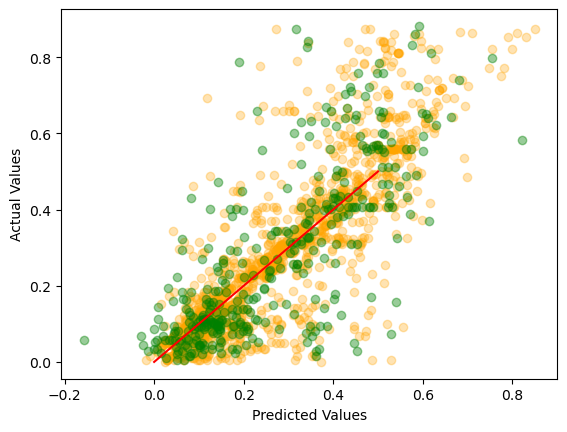

In [ ]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

Ni

In [ ]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-23 21:40:33,113] A new study created in memory with name: svm_parameter_opt
[I 2023-08-23 21:40:33,385] Trial 0 finished with value: 0.07018361112216458 and parameters: {'C': 2.065331414125709, 'epsilon': 0.710671270238858, 'kernel': 'poly', 'degree': 4}. Best is trial 0 with value: 0.07018361112216458.
[I 2023-08-23 21:40:34,531] Trial 1 finished with value: 0.5617752886244796 and parameters: {'C': 24.9774186636758, 'epsilon': 0.065609017579832, 'kernel': 'rbf', 'degree': 2}. Best is trial 1 with value: 0.5617752886244796.
[I 2023-08-23 21:40:36,582] Trial 2 finished with value: 0.5309498703478636 and parameters: {'C': 76.98072031171732, 'epsilon': 0.09380293941046917, 'kernel': 'rbf', 'degree': 2}. Best is trial 1 with value: 0.5617752886244796.
[I 2023-08-23 21:40:37,863] Trial 3 finished with value: 0.5586869867117722 and parameters: {'C': 21.757053849081295, 'epsilon': 0.014808116281341101, 'kernel': 'rbf', 'degree': 2}. Best is trial 1 with value: 0.5617752886244796.
[

Best r2:  0.5782765115086037
Best trial: {'C': 11.87401439445698, 'epsilon': 0.3265797473727567, 'kernel': 'rbf', 'degree': 3}


In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 11.87401439445698, 'epsilon': 0.3265797473727567, 'kernel': 'rbf', 'degree': 3}


In [ ]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Ni_X_train, Ni_y_train)

SVR(C=11.87401439445698, epsilon=0.3265797473727567)

In [ ]:
y_train_pred = svm.predict(Ni_X_train)
y_test_pred = svm.predict(Ni_X_test)

In [ ]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.5927335756050003
Test RMSE:  0.8448142139109631


In [ ]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.757882557315464
Test R2:  0.5332576136530847


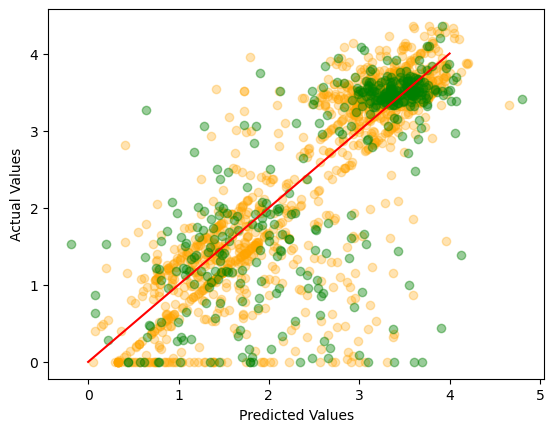

In [ ]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()